## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Helpers

In [11]:
# All imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# change qt to inline if want to embed in the cell with mpimg
%matplotlib qt

In [2]:
# Configs
CAMERA_CALIBRATION_PATH='camera_cal'
CAMERA_CALIBRATION_EXT='*.jpg'
CHECKER_BOARD_WIDTH=9
CHECKER_BOARD_HEIGHT=6

In [3]:
# Read all calibration images
def get_calibration_images():
    search_str = CAMERA_CALIBRATION_PATH+str('/')+CAMERA_CALIBRATION_EXT
    return glob.glob(search_str)

## Camera Calibration

In [62]:
def calibrate_camera(images):
    objpoints = [] # 3d object points on the checkerboard.
    imgpoints = [] # 2d image points on the image plane.
    
    # create object point mesh
    objp = np.zeros((CHECKER_BOARD_WIDTH * CHECKER_BOARD_HEIGHT, 3), np.float32)
    a = np.mgrid[0:CHECKER_BOARD_WIDTH, 0:CHECKER_BOARD_HEIGHT]
    objp[:, :2] = np.mgrid[0:CHECKER_BOARD_WIDTH, 0:CHECKER_BOARD_HEIGHT].T.reshape(-1, 2)

    for fname in images:
        # 1. Read image
        image = cv2.imread(fname)
        # 2. Convert to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # 3. find corners
        ret, corners = cv2.findChessboardCorners(gray, (CHECKER_BOARD_WIDTH, CHECKER_BOARD_HEIGHT), None)
        # 4. Add corners
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            image = cv2.drawChessboardCorners(image, (CHECKER_BOARD_WIDTH, CHECKER_BOARD_HEIGHT), corners, ret)
            #cv2.imshow('Calibration Images', image)
            #cv2.waitKey(1000)
        else:
            print('failed to find corners: ', fname)
    #cv2.destroyAllWindows()

    # calibrate camera
    reprojection_error, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    print('Final reprojection error: ', reprojection_error)
    return mtx, dist



        
    

In [63]:
def undistort_image(calibration_matrix, distortion_coeff, images):
    %matplotlib inline
    for fname in images:
        # 1. Read image
        image = cv2.imread(fname)
        # 2. Convert to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # 3. Undistort image for validation
        undistorted = cv2.undistort(image, calibration_matrix, distortion_coeff, None, calibration_matrix)
            
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undistorted)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        #break

failed to find corners:  camera_cal/calibration5.jpg
failed to find corners:  camera_cal/calibration4.jpg
failed to find corners:  camera_cal/calibration1.jpg
Final reprojection error:  1.0298153371058978


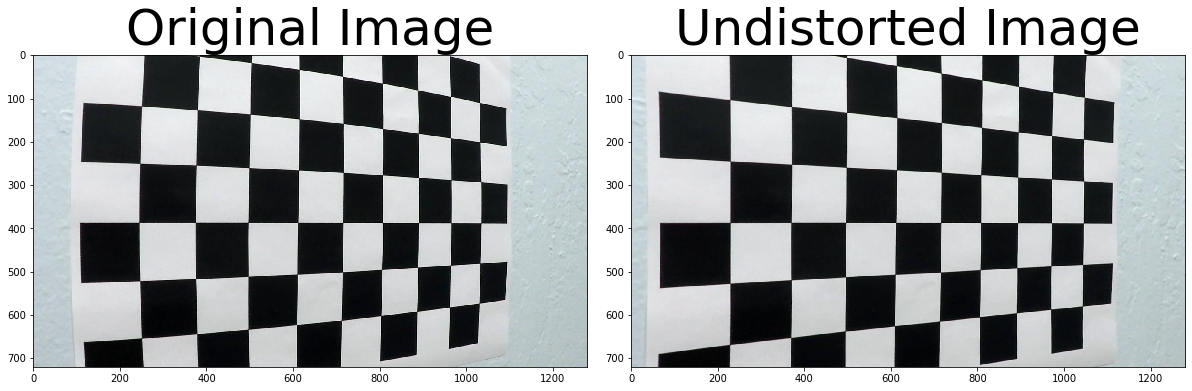

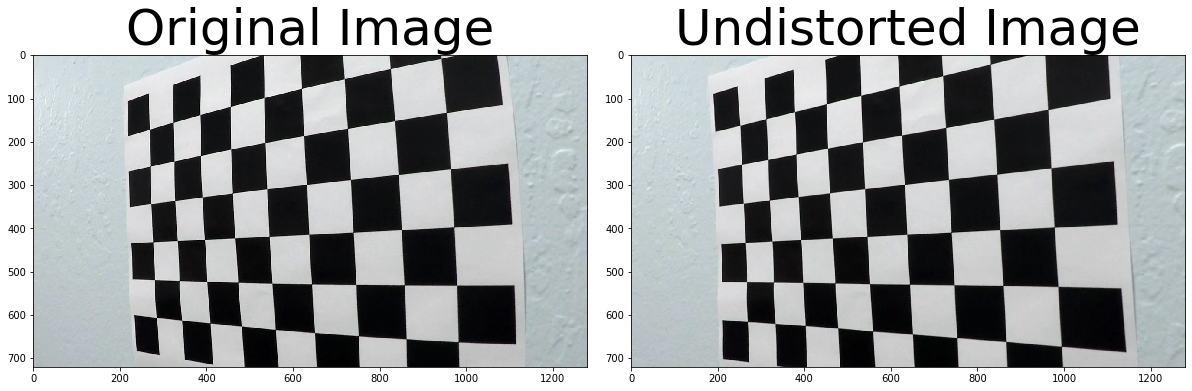

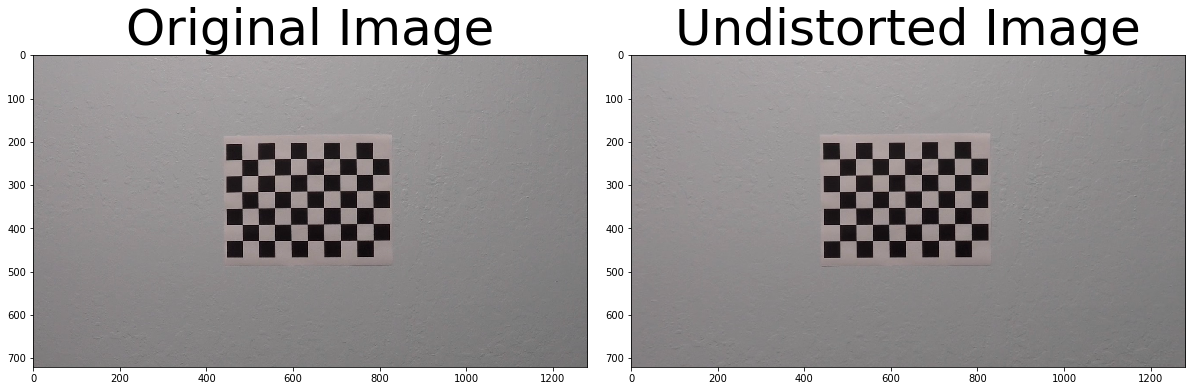

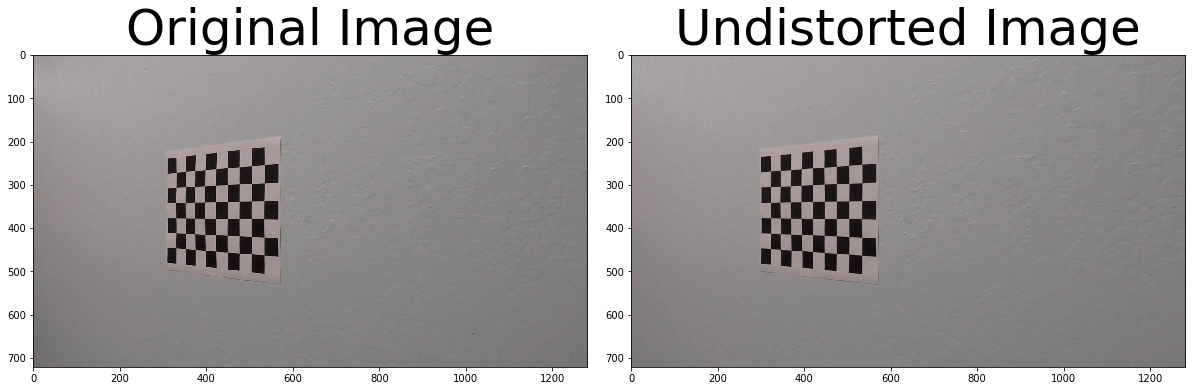

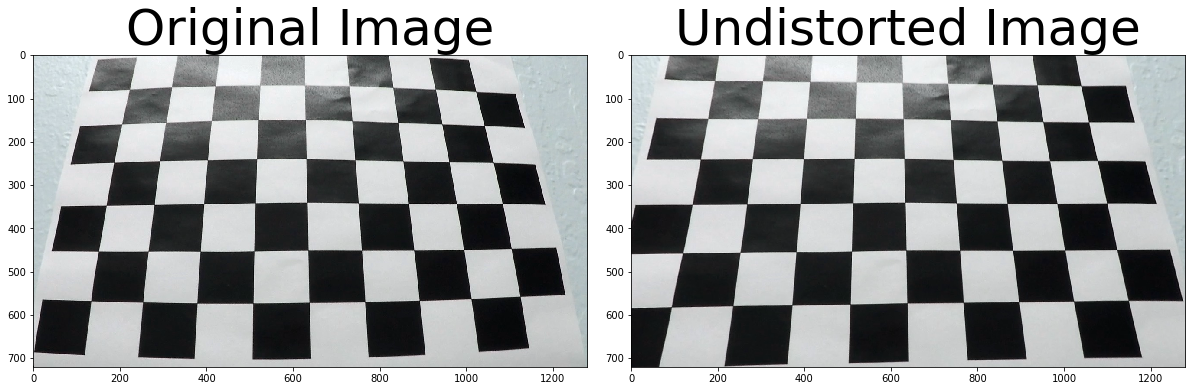

In [ ]:
images = get_calibration_images()
calibration_matrix, distortion_coeff = calibrate_camera(images)
undistort_image(calibration_matrix, distortion_coeff, images)


## Distortion Correction

## Color Transform

## Perspective Transform

## Lane Boundary

## Curvature